In [3]:
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
from tifffile import imread
import os
from scipy.stats import zscore
from sklearn.metrics import pairwise_distances
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr
from tqdm import tqdm
import seaborn as sns
import pickle

# marker names for immune, tumor, and their overlap
immune_markers = ['DNA_1','CD3', 'PDL1', 'GRZB','Ki67', 'PanCK', 'CD45','CD68', 'CD3d', 'CD8a',
             'CD163', 'aSMA', 'CD14','CD4', 'FOXP3', 'PDL1_2','CD11b', 'pRB', 'PD1',
             'LaminABC', 'PDL1_3', 'LAG3','CD20', 'HLA_A', 'MHC_II_DPB1']
tumor_markers = ['DNA_1','CD3', 'pERK', 'Rad51','CCND1', 'Vimentin', 'aSMA','Ecad', 'ER', 'PR',
            'EGFR', 'pRB', 'HER2','Ki67', 'CD45', 'p21','CK14','CK19', 'CK17',
            'LaminABC', 'AR', 'H2Ax','PCNA','PanCK', 'CD31']
shared_markers = ['DNA_1','CD3','aSMA','pRB','PanCK','CD45','Ki67','LaminABC']
def ids_to_table(ids, table):
    match_table = table[table['CellID'].isin(ids)] # get relevant rows
    df1 = match_table.set_index('CellID')
    match_table = df1.reindex(ids) # set new table in correct order
    return match_table

def get_correlations(markers, immune_table, tumor_table):
    correlations = []
    for i,s in enumerate(markers):
        correlations.append(spearmanr(immune_table[s],tumor_table[s])[0])
    return correlations

In [23]:
radii = [i for i in range(300)]
results = {}
cores = ['B3']
for core in cores:
    # read tCyCIF data
    tracked = pd.read_csv(f'/home/groups/ChangLab/heussner/tma-integration/results/Cell_tracking/{core}.csv')
    tracked = tracked[tracked['tumor_id']>0]
    #all cells tables
    path = '/home/groups/ChangLab/heussner/tma-integration/data/nuc_cell_tables'
    tumor_all = pd.read_csv(os.path.join(path,f'{core}_tCyCIF_tumor_both.csv'))
    immune_all = pd.read_csv(os.path.join(path,f'{core}_tCyCIF_immune_both.csv'))

    immune_tracked = ids_to_table(tracked['immune_id'], immune_all)
    tumor_tracked = ids_to_table(tracked['tumor_id'], tumor_all)
    overlap = []
    correlations = []
    #normalize tracked cells based on full population
    immune_all_norm = immune_all[immune_markers].copy()
    immune_all_norm = zscore(immune_all_norm,axis=0)
    immune_all_norm['CellID'] = immune_all['CellID'].copy()
    immune_tracked_norm = ids_to_table(tracked['immune_id'], immune_all_norm)
    
    immune = immune_tracked_norm[shared_markers].copy()
    tumor = tumor_all[shared_markers].copy()
    
    #immune = zscore(np.log(immune),axis=0)
    tumor = zscore(tumor,axis=0)
    #spearman correlation distance
    immune_cdist = corr_dist(immune.to_numpy(), tumor.to_numpy())

    #normalize tracked cells based on full population
    tumor_all_norm = tumor_all[tumor_markers].copy()
    tumor_all_norm = zscore(tumor_all_norm,axis=0)
    tumor_all_norm['CellID'] = tumor_all['CellID'].copy()
    tumor_tracked_norm = ids_to_table(tracked['tumor_id'], tumor_all_norm)

    # load matrices
    tumor = tumor_tracked_norm[shared_markers].copy()
    immune = immune_all[shared_markers].copy()
    immune = zscore(immune,axis=0)
    tumor_cdist = corr_dist(tumor.to_numpy(),immune.to_numpy())
    
    for r in tqdm(radii):
        #normalize tracked cells based on full population
        immune_all_norm = immune_all[immune_markers].copy()
        immune_all_norm = zscore(immune_all_norm,axis=0)
        immune_all_norm['CellID'] = immune_all['CellID'].copy()
        immune_tracked_norm = ids_to_table(tracked['immune_id'], immune_all_norm)
        
        immune = immune_tracked_norm[shared_markers].copy()
        tumor = tumor_all[shared_markers].copy()
        
        tumor = zscore(tumor,axis=0)
    
        #euclidean distance between target cells
        cols = ['x','y']
        tumor_spatial = tumor_all[cols].to_numpy()
        sdist = pairwise_distances(tumor_spatial, tumor_spatial)
    
        matched_indexes = [tumor_all[tumor_all['CellID']==i].index for i in list(tracked['tumor_id'])]

        dist = immune_cdist.copy()
        
        for i,match in enumerate(matched_indexes):
            # get target indices within radius r from sdist
            row = sdist[match,:].copy()
            indexes = list(np.where(row<=r))
            # replace values in cdist
            mask = np.ones(dist[i,:].size, dtype=bool)
            mask[indexes] = False
            dist[i,:][mask] = np.inf
    
        rows, cols = linear_sum_assignment(dist)
        scores = np.array([dist[i, j] for i, j in zip(rows, cols)])
        matching = [rows, cols, scores]
    
        #convert immune index to CellID
        matching_immune = [tracked['immune_id'], [tumor_all['CellID'].iloc[c] for c in cols], scores]
        
        #normalize tracked cells based on full population
        tumor_all_norm = tumor_all[tumor_markers].copy()
        tumor_all_norm = np.log1p(tumor_all_norm)
        tumor_all_norm = zscore(tumor_all_norm)
        tumor_all_norm['CellID'] = tumor_all['CellID'].copy()
        tumor_tracked_norm = ids_to_table(tracked['tumor_id'], tumor_all_norm)
    
        # load matrices
        tumor = tumor_tracked_norm[shared_markers].copy()
        immune = immune_all[shared_markers].copy()
        
        immune = zscore(np.log(immune),axis=0)
        cdist = tumor_cdist.copy()
        
        #euclidean distance between target cells
        cols = ['x','y']
        immune_spatial = immune_all[cols].to_numpy()
        sdist = pairwise_distances(immune_spatial, immune_spatial)
    
        matched_indexes = [immune_all[immune_all['CellID']==i].index for i in list(tracked['immune_id'])]
        dist = tumor_cdist.copy()
        
        for i,match in enumerate(matched_indexes):
            # get target indices within radius r from sdist
            row = sdist[match,:].copy()
            indexes = list(np.where(row<=r))
            # replace values in cdist
            mask = np.ones(dist[i,:].size, dtype=bool)
            mask[indexes] = False
            dist[i,:][mask] = np.inf
        
        rows, cols = linear_sum_assignment(dist)
        scores = np.array([dist[i, j] for i, j in zip(rows, cols)])
        matching = [rows, cols, scores]

        matching_immune = [[immune_all['CellID'].iloc[c] for c in cols], tracked['tumor_id'], scores]
        
        # create sets
        immuneSet = set((x,y) for x,y in zip(matching_immune[0], matching_immune[1]))
        tumorSet = set((x,y) for x,y in zip(matching_tumor[0], matching_tumor[1]))
        intersection = immuneSet.intersection(tumorSet)
        immuneUnique = immuneSet.difference(tumorSet)
        tumorUnique = tumorSet.difference(immuneSet)
    
        tumor_both = []
        immune_both = []
        for m in intersection:
            tumor_both.append(m[1])
            immune_both.append(m[0])
    
        tm_table = ids_to_table(tumor_both, tumor_all)
        im_table = ids_to_table(immune_both, immune_all)
        correlations.append(np.mean(get_correlations(shared_markers,im_table,tm_table)))
        overlap.append(len(intersection)/len(immune_tracked))
    results[core]=[overlap,correlations]

with open('cyclic_consistency.pkl','wb') as handle:
    pickle.dump(results, handle)

100%|█| 300/300 [1:06:47<0


In [4]:
with open('cyclic.pkl','rb') as handle:
    results = pickle.load(handle)

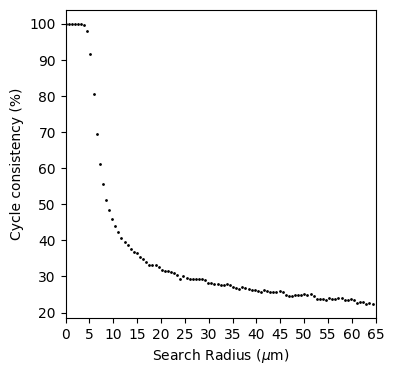

In [6]:
r = [i*0.65 for i in range(200)][0:100]
y = results['B3'][0][0:100]
plt.figure(figsize=(4,4))
plt.scatter(r,[i*100 for i in y], s=1, color='black')
plt.xlabel(r'Search Radius ($\mu$m)')
plt.xticks([i*5 for i in range(14)])
plt.xlim([0,65])
plt.ylabel('Cycle consistency (%)')
plt.show()